In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete, Box

import matplotlib.pyplot as plt

In [173]:
class CocaineWorld(gym.Env):
    

    def __init__(self, actions=40, trial_length = 60, lever_light_on = 5):
        
        
        self.time = 0 # time step within a single trial
        self.trial_length = trial_length # length of trial
        self.lever_light_on = lever_light_on # how long the lever light is on for 
        
        self.k = 20 # height of drug dopamine
        self.tau = 1/6 # timescale of drug dopamine
        self.time_delay = lever_light_on + 10 #delay of drug dopamine
        self.sigma = 1 # width of drug dopamine for gaussian response
        self.release_type = 'quick_rise'
        self.drug_release = 0
        
        self.observation_space = Box(0, 1, shape=(2,))

        # We have actions, corresponding to "press cocaine lever", "press sugar lever", "scratch butt", etc
        self.action_space = Discrete(actions)
        
        self.rewards = np.random.normal(0,1, self.action_space.n)  
        self.rewards[0] = 0 # immediate drug reward
        self.rewards[1] = 0.1 # immediate sugar reward
        
        self.best_non_drug_action = np.argmax(self.rewards)
        
    def reset(self, seed = 42, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        
        self.time = 0
        self.obs = [1, 0]
        self.drug_release = 0
        
        return self.obs
    
    def _dopamine_release(self):
        if self.release_type == 'quick_rise':
            return np.maximum(0,self.k*self.tau*(self.time-self.time_delay)*np.exp(-self.tau*(self.time-self.time_delay)))
        if self.release_type == 'gauss':
            return np.maximum(0,self.k*np.exp(-(self.tau*(self.time-self.time_delay)/sigma)**2))         
    

    def step(self, action):        
        
        terminated = self.time >= self.trial_length #check to make sure trial is not done
        
        reward = self.rewards[action] #compute reward
        
        self.time += 1 # go foward one timestep in trial   
        
        if self.time >= self.lever_light_on:
            self.obs =  [0 , 1] 
            
            
        if (self.time <= self.lever_light_on) and (action == 0):
            self.drug_release = 1
            
        d = self._dopamine_release()
        reward += self.drug_release * d
        
        
        return self.obs, reward, self.drug_release * d, terminated

# Train MLP on addiction task (very simple)

In [176]:
def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def train(hidden_sizes=[32], lr = 1e-2, 
          epochs=50, batch_size=5000):

    # make environment, check spaces, get obs / act dims
    env = CocaineWorld()

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

    # make function to compute action distribution
    def get_policy(obs):
        logits = logits_net(obs)
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_drugs = []
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep
        ep_drugs = []            # list for drug accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:                           

            # save obs
            batch_obs.append(obs)

            # act in the environment
            act = get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, rew, drug, done = env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)
            ep_drugs.append(drug)

            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_drugs.append(ep_drugs)
                

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += [ep_ret] * ep_len
                

                # reset episode-specific variables
                obs, done, ep_rews, ep_drugs = env.reset(), False, [], []
                

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

                    
        batch_obs = np.stack(batch_obs)       
        batch_acts = np.stack(batch_acts) 
        batch_weights = np.stack(batch_weights)
        batch_drugs = np.stack(batch_drugs)
        
        #print(batch_acts[0:5])
        
       
        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32),
                                  weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                                  )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_acts, batch_drugs
    
    rewards_over_epochs = []
    acts_over_epochs = []
    drug_over_epochs = []

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_acts, batch_drugs = train_one_epoch()
        
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t drug: %.3f '% 
                (i, batch_loss, np.mean(batch_rets),np.mean(batch_drugs)))

        rewards_over_epochs.append(np.mean(batch_rets))
        acts_over_epochs.append(np.mean(batch_acts))
        drug_over_epochs.append(np.mean(batch_drugs))

    return rewards_over_epochs,drug_over_epochs,acts_over_epochs,env, logits_net

epoch:   0 	 loss: 0.312 	 return: -0.011 	 drug: 0.115 
epoch:   1 	 loss: 50.958 	 return: 14.137 	 drug: 0.345 
epoch:   2 	 loss: 50.144 	 return: 13.747 	 drug: 0.345 
epoch:   3 	 loss: -13.003 	 return: -3.680 	 drug: 0.115 
epoch:   4 	 loss: 18.337 	 return: 5.100 	 drug: 0.230 
epoch:   5 	 loss: 31.293 	 return: 8.367 	 drug: 0.230 
epoch:   6 	 loss: 40.145 	 return: 11.253 	 drug: 0.230 
epoch:   7 	 loss: -14.765 	 return: -4.122 	 drug: 0.000 
epoch:   8 	 loss: 123.802 	 return: 34.658 	 drug: 0.575 
epoch:   9 	 loss: 137.802 	 return: 38.815 	 drug: 0.690 
epoch:  10 	 loss: 91.315 	 return: 25.808 	 drug: 0.460 
epoch:  11 	 loss: 137.491 	 return: 38.790 	 drug: 0.690 
epoch:  12 	 loss: 176.792 	 return: 50.483 	 drug: 0.805 
epoch:  13 	 loss: 141.147 	 return: 39.884 	 drug: 0.690 
epoch:  14 	 loss: 296.387 	 return: 84.373 	 drug: 1.380 
epoch:  15 	 loss: 169.668 	 return: 48.369 	 drug: 0.805 
epoch:  16 	 loss: 134.808 	 return: 39.106 	 drug: 0.690 
epoch: 

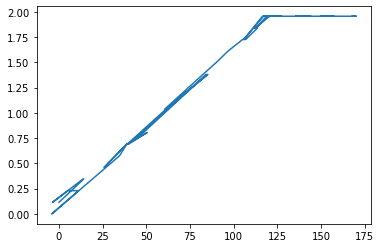

In [177]:

lr = 1e-2


rewards_over_epochs,drug_over_epochs,acts_over_epochs,env,logits_net = train(lr=lr,epochs=100, batch_size=1000)

plt.plot(rewards_over_epochs,drug_over_epochs)
#print(acts_over_epochs)

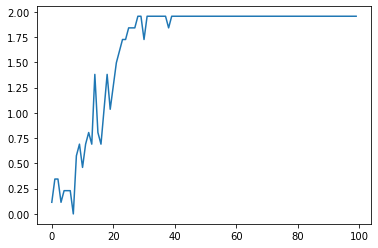

In [178]:
plt.plot(drug_over_epochs)